# Assignment #1: SIFT Feature Matching & Panorama Stitching

### Goal
In this assignment, you will implement a complete image stitching pipeline using **Scale-Invariant Feature Transform (SIFT)** for feature detection and matching. Your task is to create a panoramic image by automatically aligning and blending overlapping photographs.  

This is an **individual project**, so you are expected to complete the work independently.  

Several parts of the pipeline have already been provided. Your responsibilities are to:  
- Complete the **TODO** sections.  
- Test your implementation on different image pairs.  
- Report and analyze your results.  

---

### Instructions
Replace each **TODO** block with your own code.  

Feel free to add extra cells in the notebook to:  
- Display intermediate visualizations (e.g., keypoints, matches, warped images).  
- Explain and discuss your results.  


In [9]:
from __future__ import annotations
import cv2
import numpy as np
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt

In [ ]:
# Default image pair; you can override the paths later.
IMG1_PATH = Path("your image 1 path")
IMG2_PATH = Path("your image 2 path")

In [ ]:
# -----------------------------
# Load images
# -----------------------------
def load_images(path1: Path, path2: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    TODO: Load input images. OpenCV loads images in BGR order, but most tools (like Matplotlib) and our eyes expect RGB order. 
    Converting BGR → RGB ensures colors display correctly using Matplotlib. You also need to return a grayscale version of the 
    image (since SIFT operates on single-channel images).

    Steps:
      1. Use cv2.imread() to read the two images.
      2. Perform the conversions using the cv2.cvtColor function with flags such as cv2.COLOR_BGR2RGB and cv2.COLOR_BGR2GRAY. 
      3. Return original BGR, RGB, and grayscale images.

    Returns:
        img1_bgr, img2_bgr, img1_rgb, img2_rgb, img1_gray, img2_gray
    """
    return img1_bgr, img2_bgr, img1_rgb, img2_rgb, img1_gray, img2_gray

In [ ]:
# -----------------------------
# Detection & Description (TODO)
# -----------------------------
def detect_and_describe(image_gray: np.ndarray) -> Tuple[List[cv2.KeyPoint], np.ndarray]:
    """
    TODO: Detect SIFT keypoints and compute descriptors.
      - Create a SIFT detector (cv2.SIFT_create()).
      - Call detectAndCompute(image_gray, None) to get (keypoints, descriptors).
      - Return both.

    Note: SIFT requires a grayscale image as input, consistent with slides.

    Returns:
        kp: list of cv2.KeyPoint
        des: np.ndarray of shape (N, 128) for SIFT
    """
    return kp, des

In [ ]:
# -----------------------------
# Descriptor Matching (TODO)
# -----------------------------

def match_descriptors(des1: np.ndarray, des2: np.ndarray, ratio: float = 0.75) -> List[cv2.DMatch]:
    """
    TODO: Match SIFT descriptors using BFMatcher + kNN (k=2) and
    apply Lowe's ratio test.
      - bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
      - matches = bf.knnMatch(des1, des2, k=2)
      - keep m if m.distance < ratio * n.distance

    Returns:
        surviving_matches: list of cv2.DMatch that pass the ratio test
    """

    return surviving_matches

In [ ]:
# -----------------------------
# Robust model fitting and warping
# -----------------------------
def estimate_homography(kp1: List[cv2.KeyPoint], kp2: List[cv2.KeyPoint], matches: List[cv2.DMatch], ransac_thresh: float = 5.0):
    if len(matches) < 4:
        raise ValueError("Need at least 4 matches to compute a homography.")
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
    if H is None:
        raise RuntimeError("Homography estimation failed.")
    return H, mask.ravel().tolist()


def warp_and_compose(img1: np.ndarray, img2: np.ndarray, H: np.ndarray):
    h2, w2 = img2.shape[:2]
    h1, w1 = img1.shape[:2]

    # Warp the corners of img1 into img2's frame
    corners_img1 = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Combine with img2 corners to get panorama bounding box
    all_corners = np.concatenate(
        (warped_corners, np.float32([[0, 0], [w2, 0], [w2, h2], [0, h2]]).reshape(-1, 1, 2)),
        axis=0,
    )
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = [-x_min, -y_min]
    Tx = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    panorama_size = (x_max - x_min, y_max - y_min)

    warped_img1 = cv2.warpPerspective(img1, Tx @ H, panorama_size)

    # Paste img2 onto panorama canvas
    panorama = warped_img1.copy()
    panorama[
        translation[1] : translation[1] + h2,
        translation[0] : translation[0] + w2,
    ] = img2

    return panorama, warped_img1, translation, (h2, w2)


In [ ]:
# -----------------------------
# Feather blending
# -----------------------------
def feather_blend(warped_img1: np.ndarray, panorama: np.ndarray, translation: Tuple[int, int], size_img2: Tuple[int, int]) -> np.ndarray:
    (h2, w2) = size_img2
    ty, tx = translation[1], translation[0]

    mask1 = (warped_img1.sum(axis=2) > 0).astype(np.float32)
    mask2 = np.zeros_like(mask1)
    mask2[ty : ty + h2, tx : tx + w2] = 1.0

    def distance_transform(mask: np.ndarray) -> np.ndarray:
        m = (mask * 255).astype(np.uint8)
        dist = cv2.distanceTransform(m, cv2.DIST_L2, 3)
        if dist.max() > 0:
            dist = dist / dist.max()
        return dist

    w1 = distance_transform(mask1) + 1e-6
    w2 = distance_transform(mask2) + 1e-6
    wsum = w1 + w2
    w1n = w1 / wsum
    w2n = w2 / wsum

    warped_f = warped_img1.astype(np.float32)
    pano_f = panorama.astype(np.float32)
    blended = warped_f * w1n[..., None] + pano_f * w2n[..., None]
    return np.clip(blended, 0, 255).astype(np.uint8)

In [ ]:
# -----------------------------
# Provided: crop & visualization
# -----------------------------
def crop_nonempty(img: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    x, y, w, h = cv2.boundingRect(thresh)
    return img[y : y + h, x : x + w]


def draw_inlier_matches(img1_rgb: np.ndarray, img2_rgb: np.ndarray,
                        kp1: List[cv2.KeyPoint], kp2: List[cv2.KeyPoint],
                        matches: List[cv2.DMatch], inlier_mask: List[int]) -> np.ndarray:
    inliers = [m for i, m in enumerate(matches) if inlier_mask[i]]
    viz = cv2.drawMatches(
        img1_rgb, kp1,
        img2_rgb, kp2,
        inliers, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    return viz

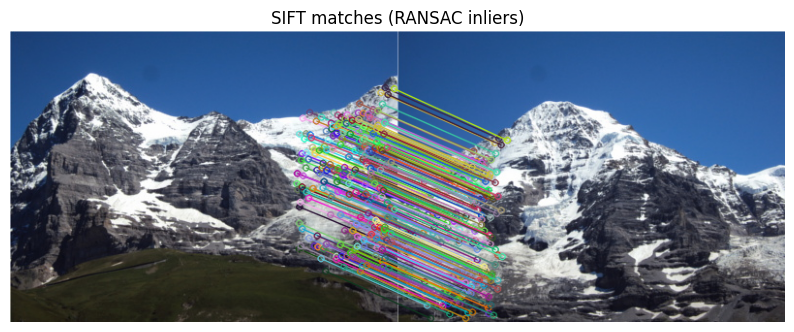

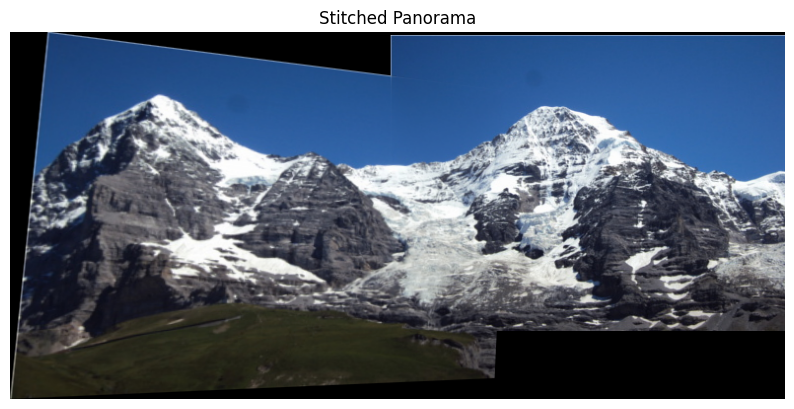

In [ ]:
# -----------------------------
# Main pipeline
# -----------------------------
def run_pipeline(img1_path: Path = IMG1_PATH, img2_path: Path = IMG2_PATH):
    # Step 0: Load images (bgr + rgb + grayscale) — TODO zone
    img1_bgr, img2_bgr, img1_rgb, img2_rgb, img1_gray, img2_gray = load_images(img1_path, img2_path)

    # Step 1: Detection & Description — TODO zone
    kp1, des1 = detect_and_describe(img1_gray)
    kp2, des2 = detect_and_describe(img2_gray)

    # Step 2: Matching — TODO zone
    matches = match_descriptors(des1, des2, ratio=0.75)

    # Step 3: Robust homography (provided)
    H, inlier_mask = estimate_homography(kp1, kp2, matches, ransac_thresh=5.0)

    # Step 4: Warp & compose (provided)
    panorama, warped_img1, translation, size_img2 = warp_and_compose(img1_bgr, img2_bgr, H)

    # Step 5: Feather blending (provided)
    blended = feather_blend(warped_img1, panorama, translation, size_img2)

    # Step 6: Crop (provided)
    cropped = crop_nonempty(blended)

    # Step 7: Visualize inlier matches
    match_viz = draw_inlier_matches(img1_rgb, img2_rgb, kp1, kp2, matches, inlier_mask)

    # Quick preview on screen
    plt.figure(figsize=(10, 5))
    plt.imshow(match_viz)
    plt.axis('off')
    plt.title('SIFT matches (RANSAC inliers)')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Stitched Panorama')
    plt.show()

if __name__ == "__main__":
    run_pipeline()

In [ ]:
"""
TODO: Experiment with more pairs, including both the provided samples and photos taken by yourself.
      Feel free to create as many additional cells (code, markdown, or raw) as needed.
"""


### Exporting notebook to HTML

- For **Jupyter Notebook**: Use  `File → Download as → HTML (.html)` and you can ignore/delete the rest.
- For **Google Colab**, run in a cell:
  ```python
  !jupyter nbconvert --to html Assignment1.ipynb
  
  More details:

In [1]:
!pip install nbconvert -q

In [2]:
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [4]:
!jupyter nbconvert --to html SIFT_Assignment_1.ipynb #Replace notebook name with yours

[NbConvertApp] Converting notebook SIFT_Assignment_1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1434496 bytes to SIFT_Assignment_1.html
